In [34]:
import pytesseract
import cv2
import base64
import time
from img_doc.editors.binarizer import ValleyEmphasisBinarizer
from img_doc.extractors.word_extractors import BaseWordExtractor
from img_doc.extractors.word_extractors.word_bold_extractor import PsBoldExtractor
from img_doc.extractors.block_extractors.block_extractor_from_word import KMeanBlockExtractor
from img_doc.extractors.block_extractors.block_label_extractor import *
from img_doc.data_structures import Word, Block
from img_doc.data_structures import Image, ImageSegment
import numpy as np
from typing import List
from io import StringIO
import json
import os


kmeanext = KMeanBlockExtractor()

def read_words(name_file):
    name_json = os.path.join(path_mini_publaynet_train, name_file + ".json")
    with open(name_json, "r") as f:
        rez = json.load(f)
    words = []
    for w in rez["words"]:
        word = Word()
        word.set_two_points(w)
        words.append(word)
    return words

def read_Image(name_file):
    path_file = os.path.join(path_mini_publaynet_train, name_file )
    image = Image()
    image.set_img_from_path(path_file)
    return image
    
def get_file_dataset(dataset, model, fun_get_words):
    list_vec = []
    list_y = []
    is_into_segment = lambda point, json_seg: (json_seg["x_top_left"] < point[0] and json_seg["x_bottom_right"] > point[0] and
                                               json_seg["y_top_left"] < point[1] and json_seg["y_bottom_right"] > point[1])
    i = 0
    len_doc = len(dataset["documents"])
    for doc in dataset["documents"]:
        print(f"   {i/len_doc*100:.2f}%" + " "*80, end="\r")

        words = fun_get_words(doc["image64"])
        list_seg = [seg for seg in dataset["segments"] if seg["document_id"] == doc["id"]]
        if words:
            for seg in list_seg:
                try:
                    seg_words = [word for word in words if is_into_segment(word.segment.get_center(), json.loads(seg["json_data"]))]
                    list_vec.append(model.get_vec_from_words(seg_words, len_vec=model.param["len_vec"]).tolist())
                    list_y.append(seg["marking_id"])
                except:
                    print(doc["image64"])
                
            i+=1
    return {"x": list_vec, "y": list_y}

def get_dataset_from_dir(path_dir, balans = 1000):
    train_images = os.path.join(path_dir, "train")
    with open(os.path.join(path_dir, "train.json"), "r") as f:
        train_json = json.load(f)
    dataset = dict()
    dataset["documents"] = [{"image64": img["file_name"], "id": img["id"]} for img in train_json["images"]]
    dataset["segments"] = []
    list_count_category = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    
    for seg in train_json["annotations"]:
        
        if list_count_category[seg["category_id"]] < balans:
            dataset["segments"].append({"json_data": "{"+f'"x_top_left":{int(seg["bbox"][0])}, "y_top_left":{int(seg["bbox"][1])}, "x_bottom_right": {int(seg["bbox"][0]+seg["bbox"][2])}, "y_bottom_right": {int(seg["bbox"][1]+seg["bbox"][3])}'+"}",
                            "marking_id": seg["category_id"],
                            "document_id": seg["image_id"]
                           })
            list_count_category[seg["category_id"]] += 1
    return dataset
        

In [35]:
path_mini_publaynet = "/home/daniil/program/dataset/mini_ts_publaynet"
path_mini_publaynet_train = "/home/daniil/program/dataset/mini_ts_publaynet/train"

In [36]:
dataset = get_dataset_from_dir(path_mini_publaynet)

In [37]:
print(len(dataset["segments"]))

5000


In [38]:
times_list = []
model = MLPRandomWalkManyDistExtractor({"model_file": "../models/model-1.sav", "len_vec": 50})
name_dataset = f"mlp_rnd_walk_dist-mini_publaynet_50.json"
start_time = time.time()
with open(name_dataset, "w") as f:
    rez = get_file_dataset(dataset, model, read_words)
    json.dump(rez, f)
    times_list.append(time.time()-start_time)

h = round(times_list[0]//3600)
m = round((times_list[0] - h*3600)//60)
s = round((times_list[0] - h*3600 -m*60))
print(f"{h} час. {m} мин. {s} сек" )

PMC5640740_00002.jpg                                                                    
PMC5760672_00005.jpg                                                                     
PMC4964951_00009.jpg                                                                     
0 час. 0 мин. 59 сек                                                                     


In [50]:
times_list

[7.361726999282837]

# Проверка датасета

In [2]:
import matplotlib.pyplot as plt

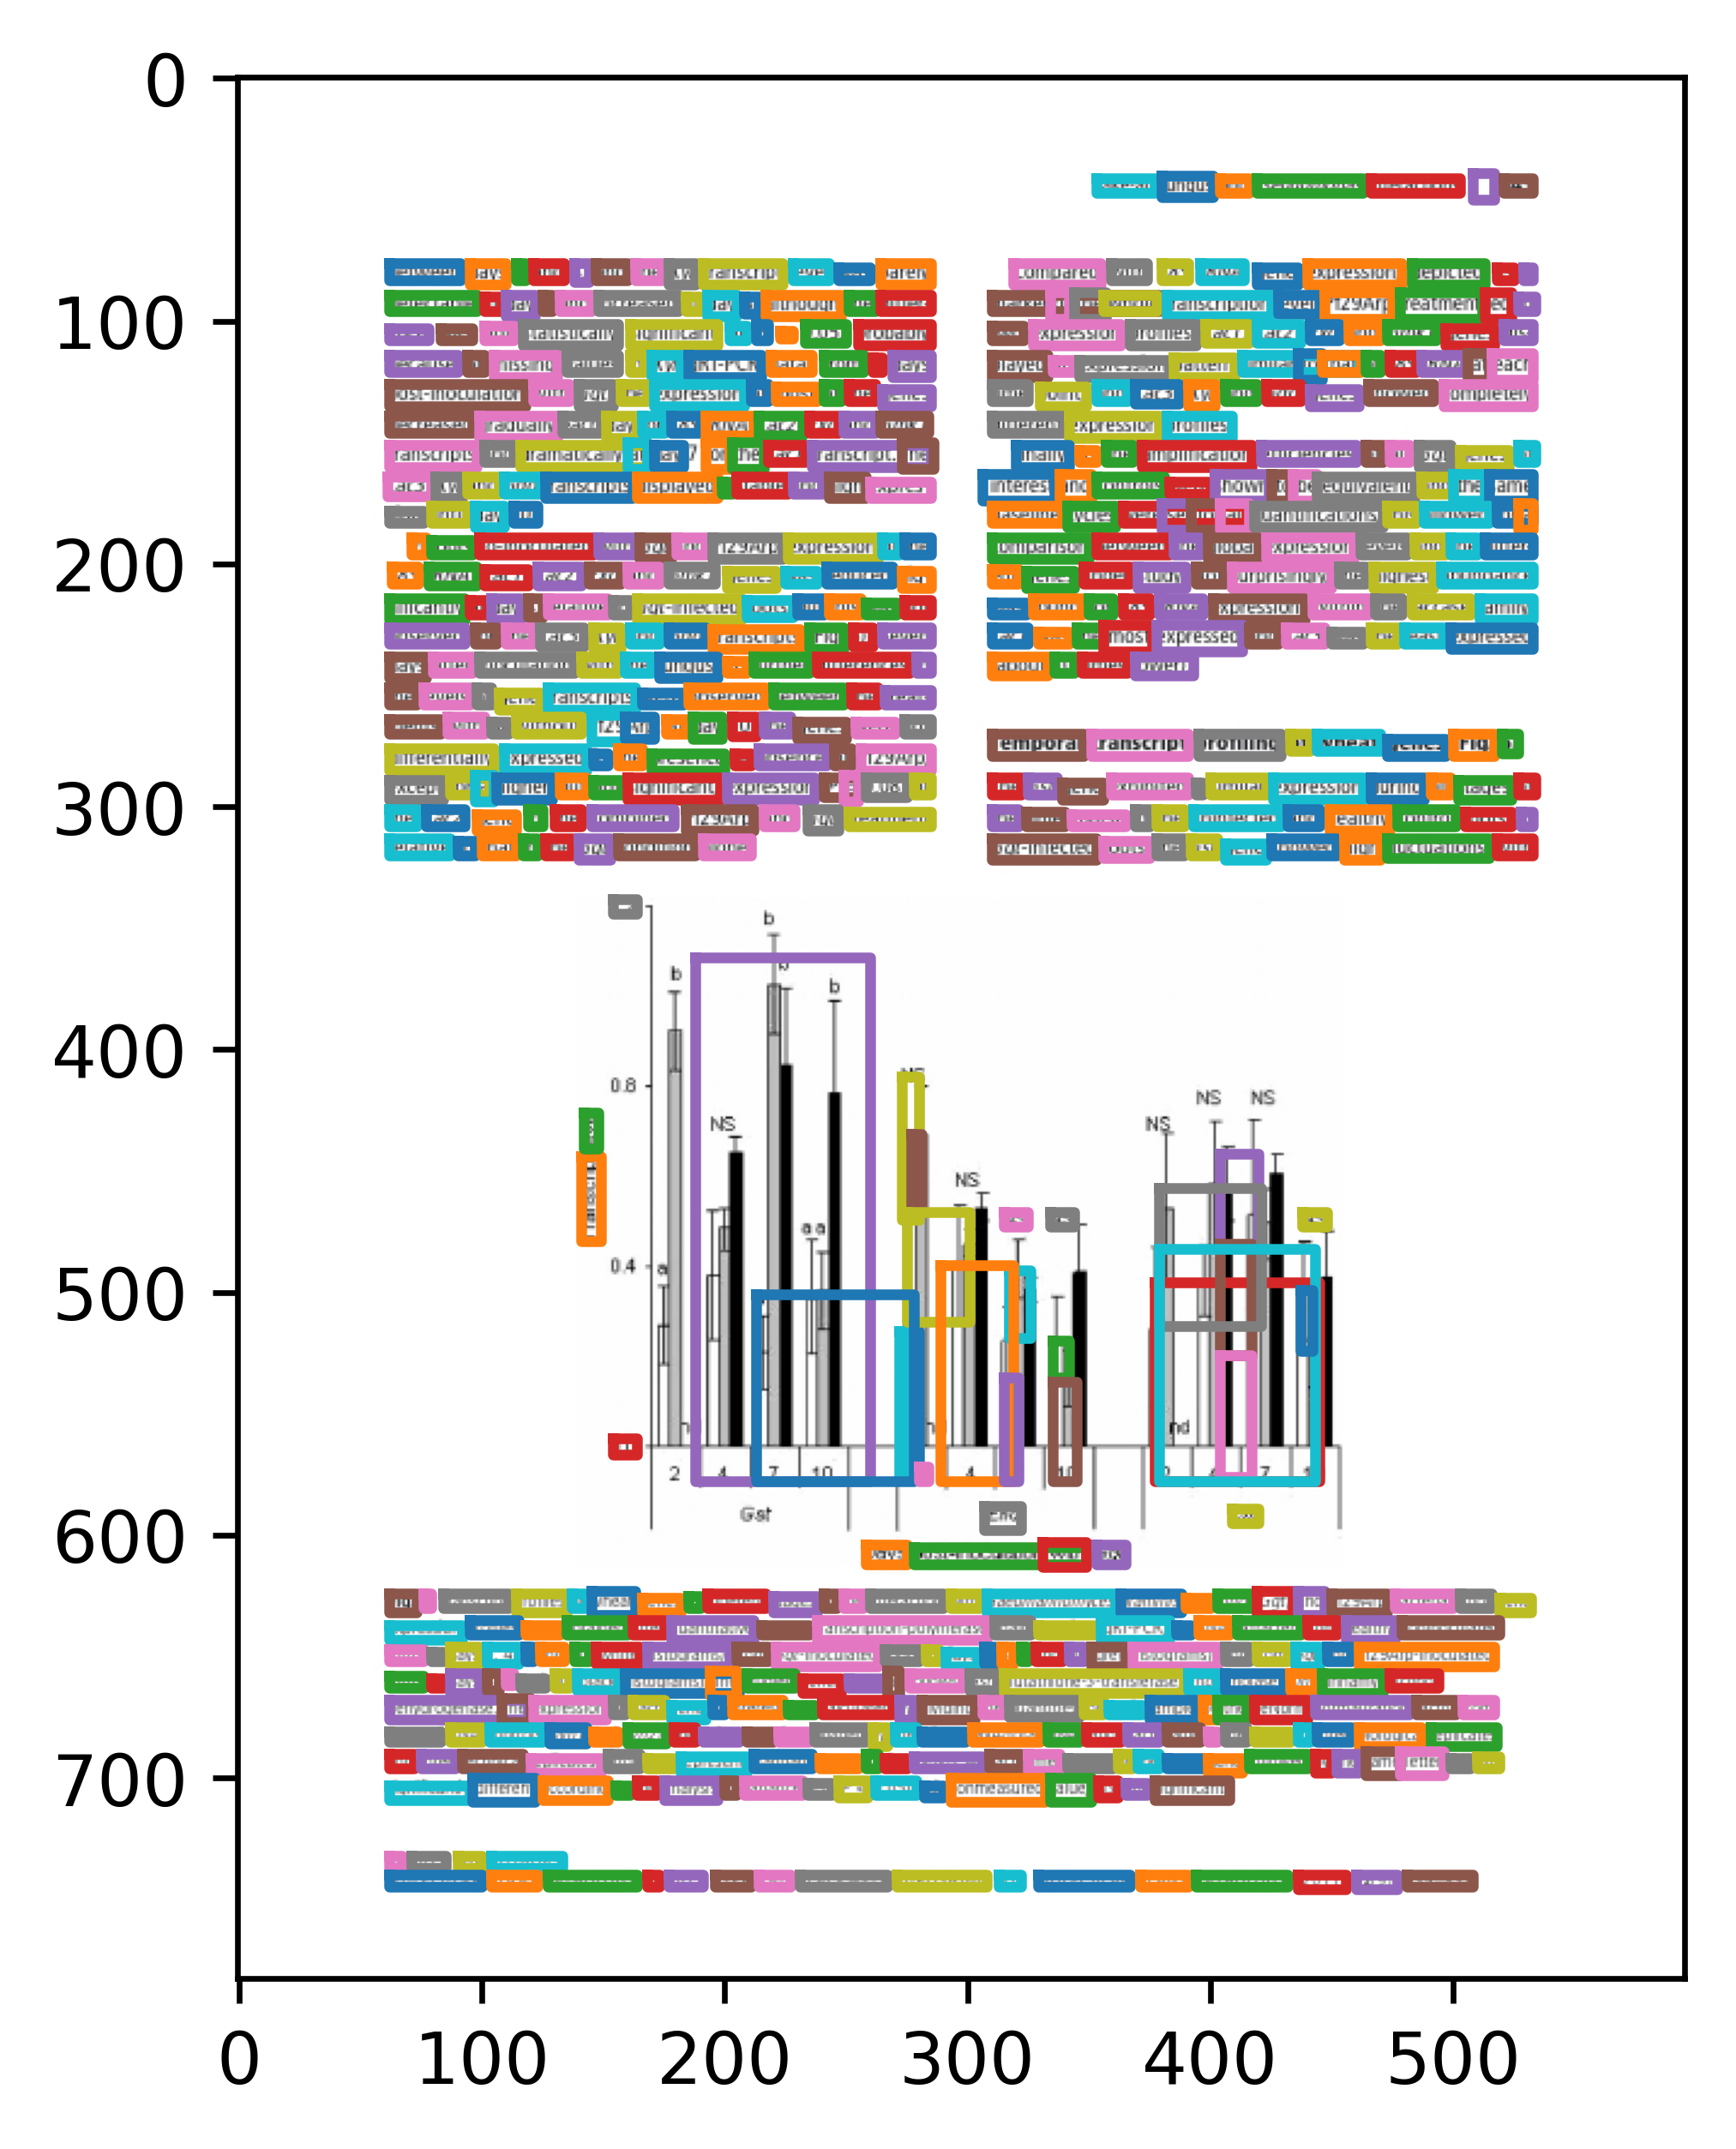

In [23]:
doc_index = 1350

doc = dataset["documents"][doc_index]
words = read_words(doc["image64"])
image = read_Image(doc["image64"])

plt.figure(dpi=600)

plt.imshow(image.img)

for word in words:
    x0 = word.segment.x_top_left
    y0 = word.segment.y_top_left
    x1 = word.segment.x_bottom_right
    y1 = word.segment.y_bottom_right
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])

In [212]:
is_into_segment = lambda point, json_seg: (json_seg["x_top_left"] < point[0] and json_seg["x_bottom_right"] > point[0] and
                                                   json_seg["y_top_left"] < point[1] and json_seg["y_bottom_right"] > point[1])

resize: 0.0006313323974609375
get box: 0.1888716220855713
create list word: 1.7881393432617188e-05


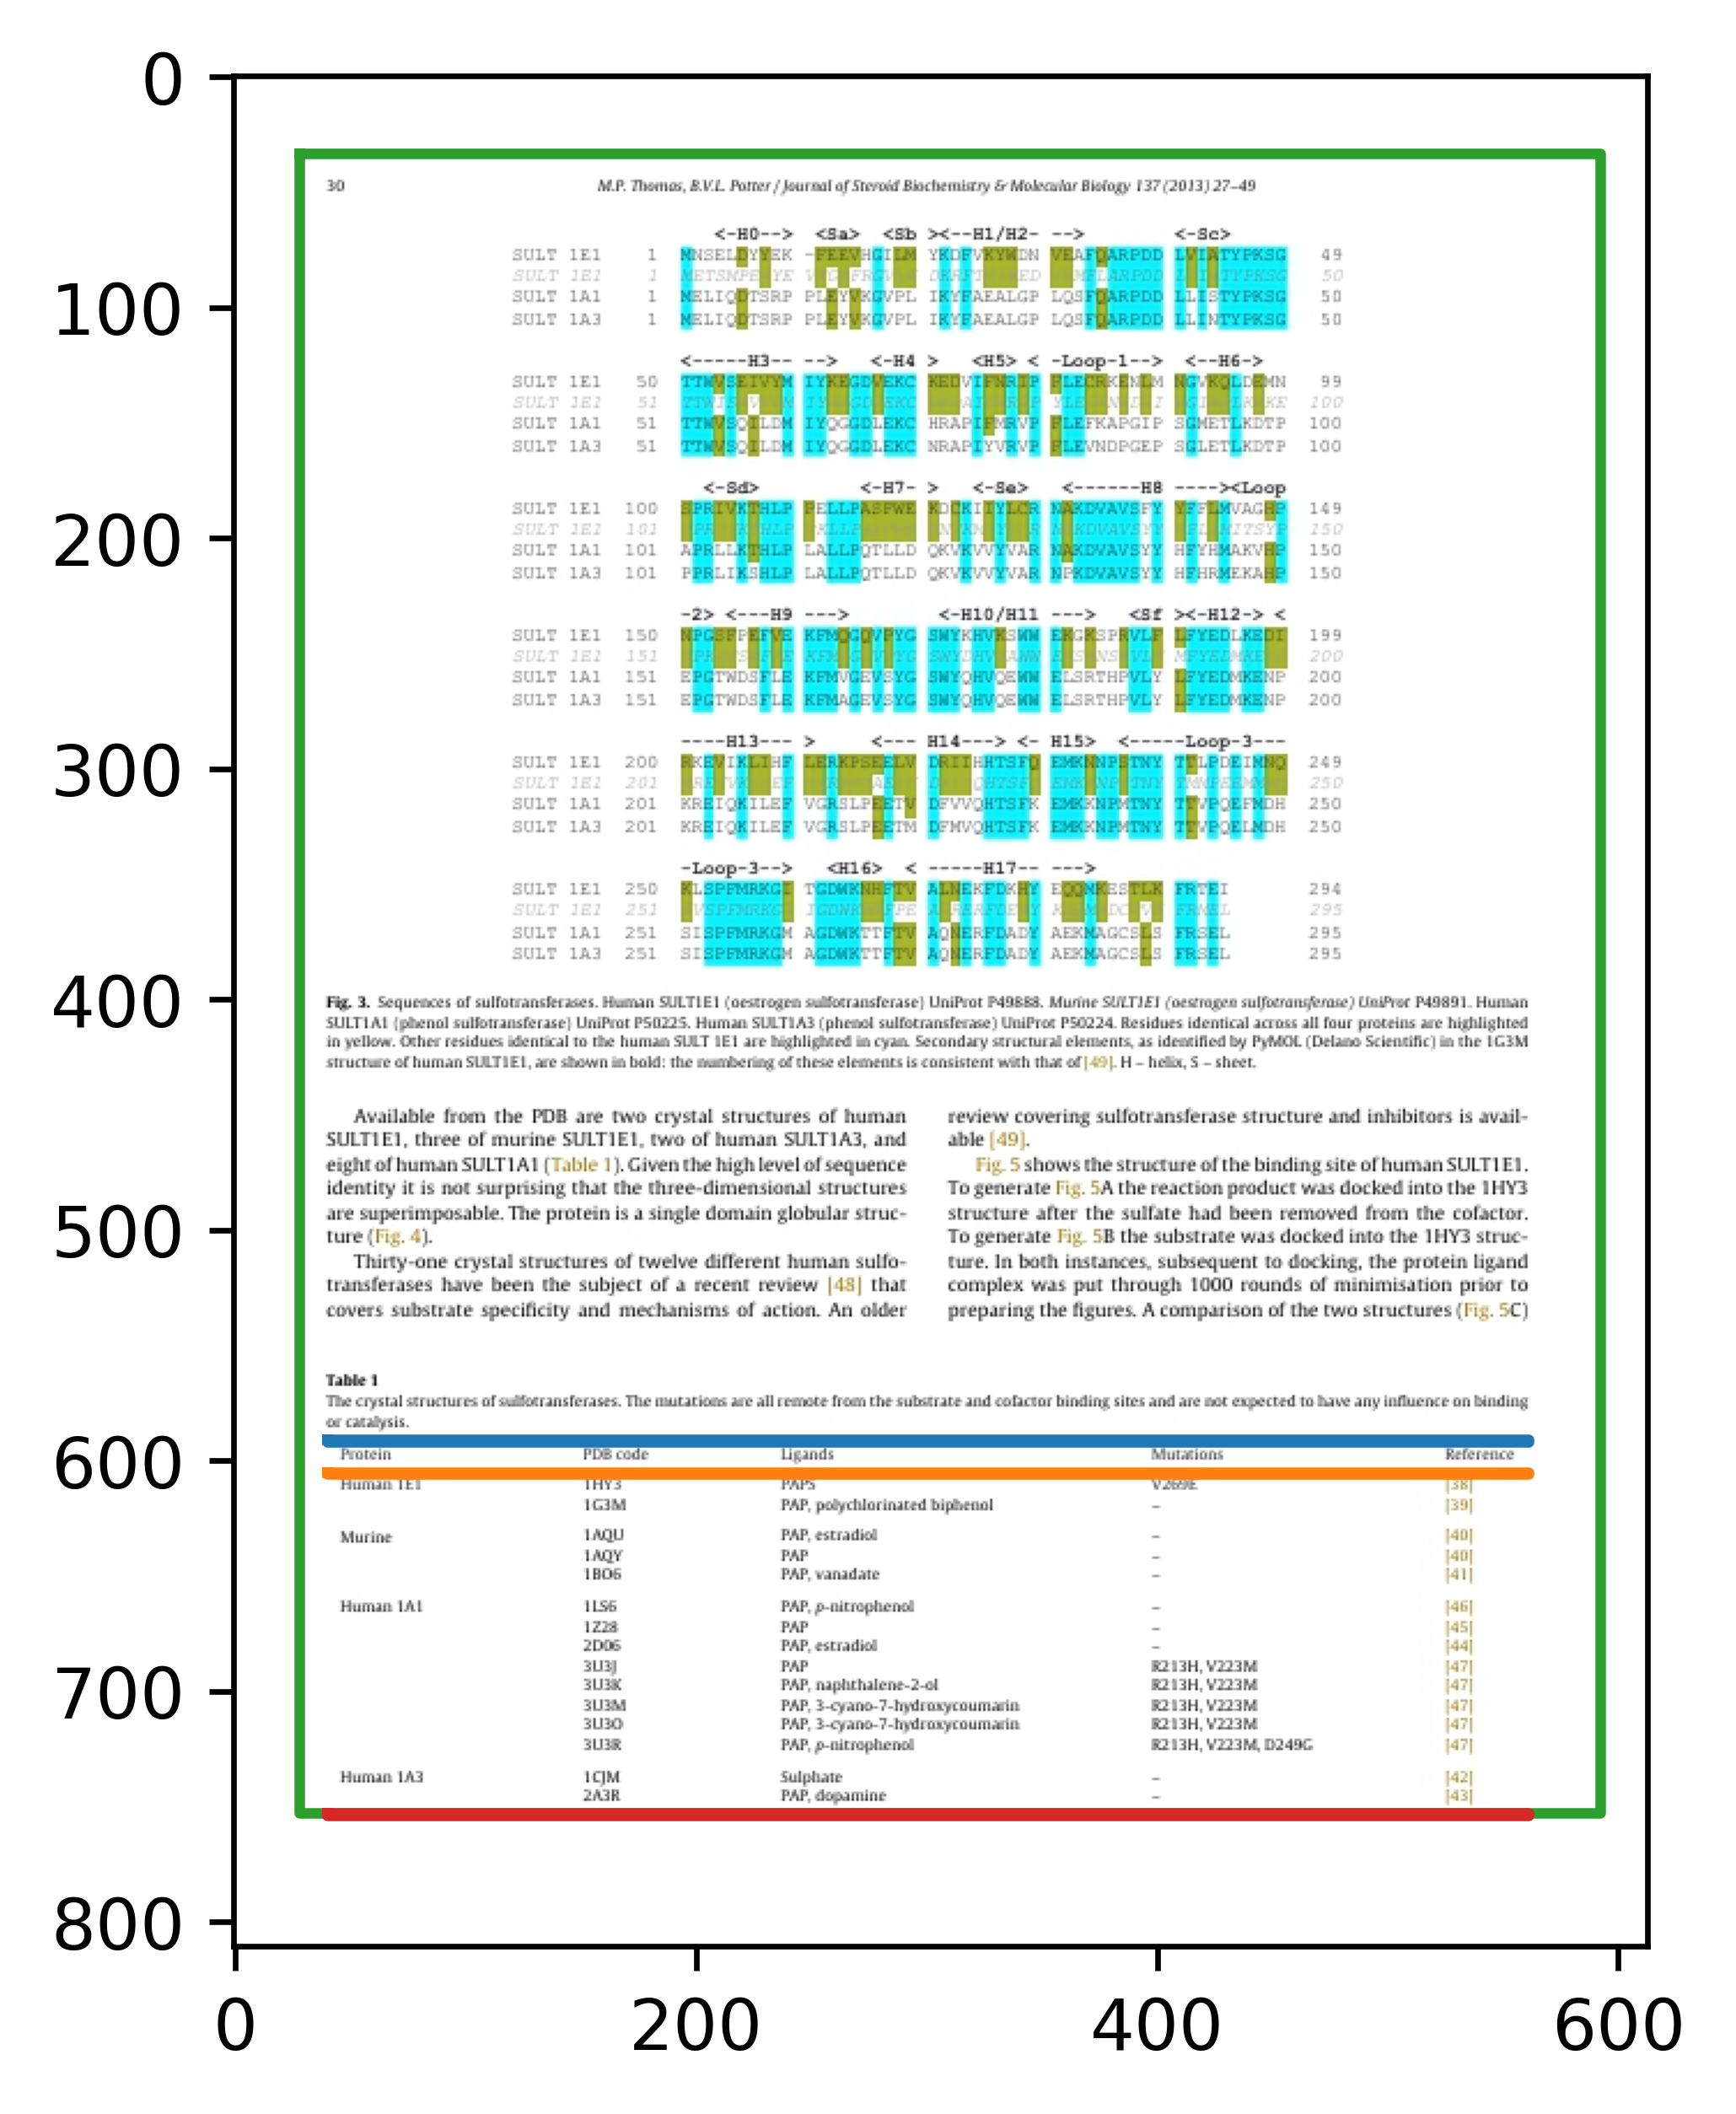

In [214]:
words = t.extract_from_img(image.img)

color = [
    "#000",
    "#00f",
    "#f00",
    "#0f0",
    "#ff0",
    "#f0f",
    "#0ff",
    "#f88",
    "#8f8"
]
plt.figure(dpi=600)
plt.imshow(image.img)
for word in words:
    # c = "#fff"
    # for i, s in enumerate(seg_0_doc):
    #     if is_into_segment( word.segment.get_center(), json.loads(s["json_data"])):
    #         c = color[i] 
    x0 = word.segment.x_top_left
    y0 = word.segment.y_top_left
    x1 = word.segment.x_bottom_right
    y1 = word.segment.y_bottom_right
    # print(word.to_dict())
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])
# for seg in seg_0_doc:
#     json_seg = json.loads(seg["json_data"])
#     x0 = json_seg["x_top_left"]
#     y0 = json_seg["y_top_left"]
#     x1 = json_seg["x_bottom_right"]
#     y1 = json_seg["y_bottom_right"]
#     plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])

4 часа 22 мин (21, 18 мин соответственно)